# Transformer Time Series Forecasting

Import Libraries

In [4]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

 Load and Preprocess the Dataset

In [5]:
# Load dataset (subset with 1000 pages)
df = pd.read_csv("train_1.csv")

# Convert from wide to long format
df_long = df.melt(id_vars=["Page"], var_name="Date", value_name="Visits")
df_long["Date"] = pd.to_datetime(df_long["Date"])
df_long["Visits"].fillna(0, inplace=True)

# Normalize traffic per page using MinMaxScaler
df_long["Visits"] = df_long.groupby("Page")["Visits"].transform(
    lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
)

# Reshape to wide format: (Date as index, Page as columns)
df_wide = df_long.pivot(index="Date", columns="Page", values="Visits").sort_index()
df_wide = df_wide[df_wide.index <= "2016-12-31"]  # Training phase only

/var/folders/y8/cj3_j50n1bgdzj77q2cx4btr0000gn/T/ipykernel_2602/2769799169.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_long["Visits"].fillna(0, inplace=True)


 Create Input & Target Sequences for Informer

In [6]:
# Define sequence lengths
WINDOW_SIZE = 60   # encoder input
LABEL_LEN = 30     # decoder past values
PRED_LEN = 30      # decoder forecast

X_enc, X_dec, Y = [], [], []

# For each time series (page), build (X_enc, X_dec) -> Y triples
for page in df_wide.columns:
    series = df_wide[page].dropna().values
    if len(series) < (WINDOW_SIZE + PRED_LEN):
        continue
    for i in range(len(series) - (WINDOW_SIZE + PRED_LEN) + 1):
        enc = series[i:i+WINDOW_SIZE]
        dec = series[i+WINDOW_SIZE-LABEL_LEN:i+WINDOW_SIZE]
        tgt = series[i+WINDOW_SIZE:i+WINDOW_SIZE+PRED_LEN]
        X_enc.append(enc)
        X_dec.append(np.concatenate([dec, np.zeros(PRED_LEN)]))  # Decoder input
        Y.append(tgt)

# Final shapes
X_enc = np.array(X_enc)[..., np.newaxis]
X_dec = np.array(X_dec)[..., np.newaxis]
Y = np.array(Y)

Create Dataset & Dataloader

In [7]:
# Custom PyTorch Dataset
class InformerDataset(Dataset):
    def __init__(self, X_enc, X_dec, Y):
        self.X_enc = torch.tensor(X_enc, dtype=torch.float32)
        self.X_dec = torch.tensor(X_dec, dtype=torch.float32)
        self.Y = torch.tensor(Y, dtype=torch.float32)

    def __len__(self):
        return len(self.X_enc)

    def __getitem__(self, idx):
        return self.X_enc[idx], self.X_dec[idx], self.Y[idx]

# Wrap in dataset object
dataset = InformerDataset(X_enc, X_dec, Y)

# Train-test split (80%-20%)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_set, test_set = random_split(dataset, [train_size, test_size])

# print(f"Train samples: {len(train_set)}")
# print(f"Test samples: {len(test_set)}")
# Dataloaders
train_loader = DataLoader(train_set, batch_size=500, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1, shuffle=False)

Define the Informer Model

In [8]:
class Informer(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, pred_len=30):
        super().__init__()
        self.enc_input = nn.Linear(input_dim, d_model)
        self.dec_input = nn.Linear(input_dim, d_model)
        self.pos_enc = nn.Parameter(torch.randn(1, 500, d_model))

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.proj = nn.Linear(d_model, 1)
        self.pred_len = pred_len

    def forward(self, enc_input, dec_input):
        # Project and add positional encoding
        enc = self.enc_input(enc_input) + self.pos_enc[:, :enc_input.size(1)]
        dec = self.dec_input(dec_input) + self.pos_enc[:, :dec_input.size(1)]

        # Transformer expects [T, B, D]
        enc = enc.permute(1, 0, 2)
        dec = dec.permute(1, 0, 2)

        memory = self.encoder(enc)
        out = self.decoder(dec, memory)
        out = self.proj(out.permute(1, 0, 2))
        return out[:, -self.pred_len:, 0]  # Return final predictions

 Train the Model

In [9]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = Informer().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(1):
    model.train()
    total_loss = 0
    for i, (enc_in, dec_in, target) in enumerate(train_loader):  # <-- FIXED HERE
        enc_in, dec_in, target = enc_in.to(device), dec_in.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(enc_in, dec_in)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if i % 100 == 0:
            print(f"Epoch {epoch+1}, Batch {i}/{len(train_loader)}, Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1}, Avg Loss: {total_loss / len(train_loader):.4f}")

/opt/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1, Batch 0/738, Loss: 0.1910
Epoch 1, Batch 100/738, Loss: 0.0145
Epoch 1, Batch 200/738, Loss: 0.0136
Epoch 1, Batch 300/738, Loss: 0.0125
Epoch 1, Batch 400/738, Loss: 0.0120
Epoch 1, Batch 500/738, Loss: 0.0114
Epoch 1, Batch 600/738, Loss: 0.0104
Epoch 1, Batch 700/738, Loss: 0.0108
Epoch 1, Avg Loss: 0.0346


Evaluate and Plot Predictions

/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, 

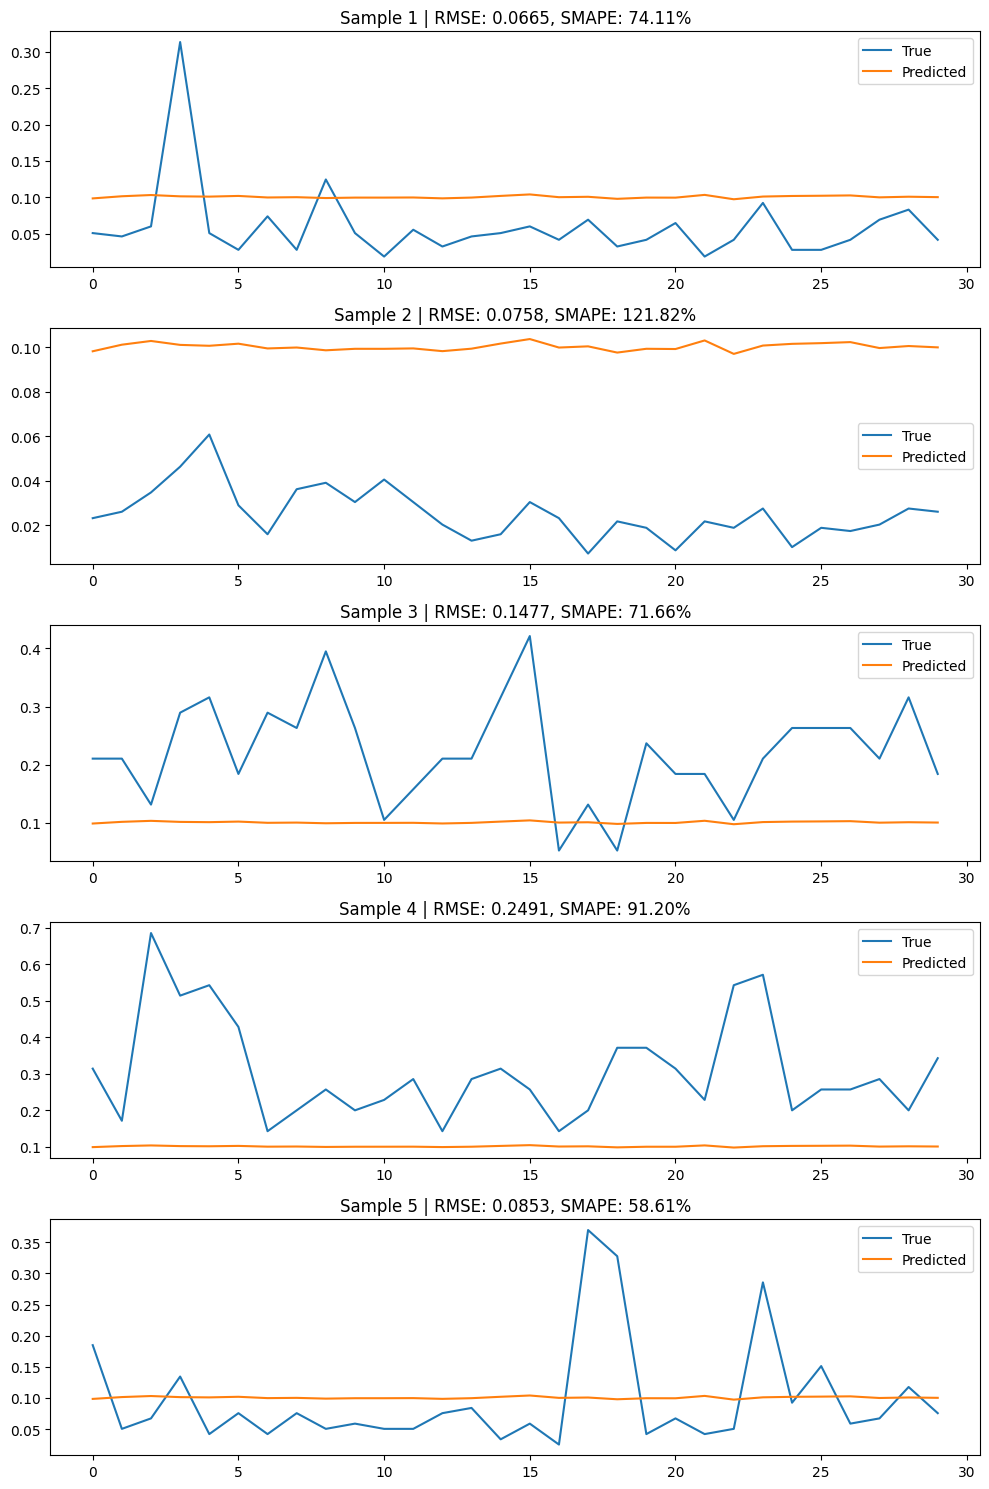

In [10]:
# SMAPE Metric
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true) + 1e-8))

# Evaluation Function
def evaluate_model(model, dataset, num_samples=5):
    model.eval()
    fig, axs = plt.subplots(num_samples, 1, figsize=(10, 3 * num_samples))

    for i in range(num_samples):
        enc_in, dec_in, target = dataset[i]
        with torch.no_grad():
            pred = model(enc_in.unsqueeze(0).to(device), dec_in.unsqueeze(0).to(device)).cpu().numpy().flatten()

        true = target.numpy()
        rmse = mean_squared_error(true, pred, squared=False)
        s = smape(true, pred)

        axs[i].plot(range(len(true)), true, label="True")
        axs[i].plot(range(len(pred)), pred, label="Predicted")
        axs[i].set_title(f"Sample {i+1} | RMSE: {rmse:.4f}, SMAPE: {s:.2f}%")
        axs[i].legend()

    plt.tight_layout()
    plt.show()

# Call evaluation on test set
evaluate_model(model, test_set)